In [1]:
#plots
import matplotlib.pylab as plt
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns; sns.set()
from matplotlib import colors
from itertools import cycle

#data
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import json
from collections import OrderedDict
from scipy.stats import norm as gauss
import random
from random import shuffle

#ML
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import keras
from keras import objectives
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D
from keras.optimizers import Adam, Nadam
from keras.objectives import binary_crossentropy #objs or losses

#chem
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import salty

#misc/scripts
import sys
sys.path.insert(0, '../')
from scripts import *

vae_models = ['Bootstrap_250k_Cation_1.h5', 'Bootstrap_1Mil_Cation_1.h5',
    '1Mil_GDB17.h5', '1Mil_GDB17_split_500k.h5', '1Mil_GDB17_split_500k_cation_500k.h5']

vae_models = ['M1.h5', 'M2.h5', 'M3.h5', 'M4.h5', 'M5.h5']

#search with single seed data
df1 = pd.read_csv('../data/structure_search_results/vae_1_structures.csv')
df2 = pd.read_csv('../data/structure_search_results/vae_2_structures.csv')
df3 = pd.read_csv('../data/structure_search_results/vae_3_structures.csv')
df4 = pd.read_csv('../data/structure_search_results/vae_4_structures.csv')
df5 = pd.read_csv('../data/structure_search_results/vae_5_structures.csv')
dfs = [df1, df2, df3, df4, df5]

#salt data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']

Using TensorFlow backend.


In [2]:
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
from sklearn.preprocessing import StandardScaler
from numpy import log
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping

from numpy import array
from keras.models import load_model
from os.path import dirname, join
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.six import iteritems
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib.pyplot import figure
from rdkit.Chem.Draw.canvasbase import CanvasBase
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)
from scipy.constants import golden as phi

def raad(y_true, y_pred):
    return np.sum(np.abs((y_pred-y_true)/y_true))/len(y_true)*100

class Canvas(CanvasBase):

  def __init__(self, size, name='', imageType='png'):
    self._name = name
    self.size = size
    dpi = max(size[0], size[1])
    figsize = (int(float(size[0]) / dpi), int(float(size[1]) / dpi))
    self._figure = figure(figsize=figsize)
    self._axes = self._figure.add_axes([0, 0, 2.5, 2.5])
    self._axes.set_xticklabels('')
    self._axes.set_yticklabels('')
    self._axes.get_xaxis().set_visible(False)
    self._axes.get_yaxis().set_visible(False)
    self._dpi = dpi

  def rescalePt(self, p1):
    return [float(p1[0]) / self._dpi, float(self.size[1] - p1[1]) / self._dpi]

  def addCanvasLine(self, p1, p2, color=(0, 0, 0), color2=None, **kwargs):
    canvas = self._axes
    p1 = self.rescalePt(p1)
    p2 = self.rescalePt(p2)
    if color2 and color2 != color:
      mp = (p1[0] + p2[0]) / 2., (p1[1] + p2[1]) / 2.
      canvas.add_line(Line2D((p1[0], mp[0]), (p1[1], mp[1]), color=color, **kwargs))
      canvas.add_line(Line2D((mp[0], p2[0]), (mp[1], p2[1]), color=color2, **kwargs))
    else:
      canvas.add_line(Line2D((p1[0], p2[0]), (p1[1], p2[1]), color=color, **kwargs))
    
  def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
    canvas = self._axes
    ps = [self.rescalePt(x) for x in ps]
    canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))
  def addCanvasText(self, text, pos, font, color=(0, 0, 0), **kwargs):
    import re
    pos = self.rescalePt(pos)
    canvas = self._axes
    text = re.sub(r'<.*?>', '', text)
    orientation = kwargs.get('orientation', 'E')
    halign = 'center'
    valign = 'center'
    if orientation == 'E':
      halign = 'left'
    elif orientation == 'W':
      halign = 'right'
    elif orientation == 'S':
      valign = 'top'
    elif orientation == 'N':
      valign = 'bottom'

    annot = canvas.annotate(text, (pos[0], pos[1]), color=color, verticalalignment=valign,
                            horizontalalignment=halign, weight=font.weight, size=font.size * 2.0,
                            family=font.face)

    try:
      bb = annot.get_window_extent(renderer=self._figure.canvas.get_renderer())
      w, h = bb.width, bb.height
      tw, th = canvas.transData.inverted().transform((w, h))
    except AttributeError:
      tw, th = 0.1, 0.1  # <- kludge
    return (tw, th, 0)

  def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
    canvas = self._axes
    ps = [self.rescalePt(x) for x in ps]
    canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))

**Training histories**

In [3]:
vae_models

['M1.h5', 'M2.h5', 'M3.h5', 'M4.h5', 'M5.h5']

In [4]:
chemvae = CationVAE()
f = open("../data/gdb_char_to_index.json", "r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
chemvae.create(char_set, max_length=51, weights_file='../models/{}'.format(vae_models[0]), qspr=False)

W0521 07:27:18.492342 139941188011840 deprecation_wrapper.py:119] From /home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0521 07:27:18.513959 139941188011840 deprecation_wrapper.py:119] From /home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0521 07:27:18.519594 139941188011840 deprecation_wrapper.py:119] From /home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0521 07:27:18.612330 139941188011840 deprecation_wrapper.py:119] From /home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3814: The name tf.random_normal is depreca

In [5]:
chemvae.autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 51, 33)       0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 43, 9)        2682        input_3[0][0]                    
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 35, 9)        738         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 25, 10)       1000        conv_2[0][0]                     
__________________________________________________________________________________________________
flatten_1 

**evolution of the latent space**

*first million training samples*

W0521 07:27:23.946295 139941188011840 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0521 07:27:24.259696 139941188011840 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


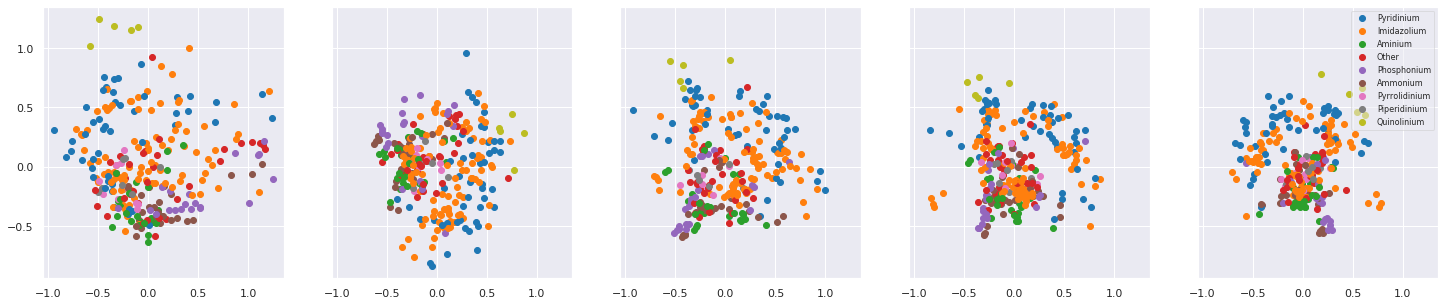

In [6]:
#cation-gdb hybrid models
cation_embeddings_final = np.load('../data/latent_arrays/cation_embeddings_final.npy')
import random
fig, axs = plt.subplots(1,5, figsize=(25,5), sharex=True, sharey=True)
axs = axs.ravel()
colors = my_colors() 
index = 0

for model in range(0,5): #plot of training data only
    z = cation_embeddings_final[model]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    for i in range(len(categories)):
        axs[model].plot(pcs[i,0], 
                        pcs[i,1],
                 linestyle='', marker='.', markersize=12,
                    color=coldic[categories[i]], alpha=1, label=categories[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=8, framealpha=0.5, frameon=True)

In [7]:
# fig.savefig('assets/final_model_latent.svg', dpi=300)

##### **Sampling in the latent space**

Models

*purist*
* M1: 250K bootstrap C+
* M2: 1000K bootstrap C+
* M3: 1000K GDB

*transfer*
* M4: M3 + 500K GDB/C+
* M5: M4 + 500K C+

4	 positively charged molecules in M1 w/o C+
4	 positively charged molecules in M2 w/o C+
4	 positively charged molecules in M3 w/o C+
4	 positively charged molecules in M4 w/o C+
4	 positively charged molecules in M5 w/o C+


/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


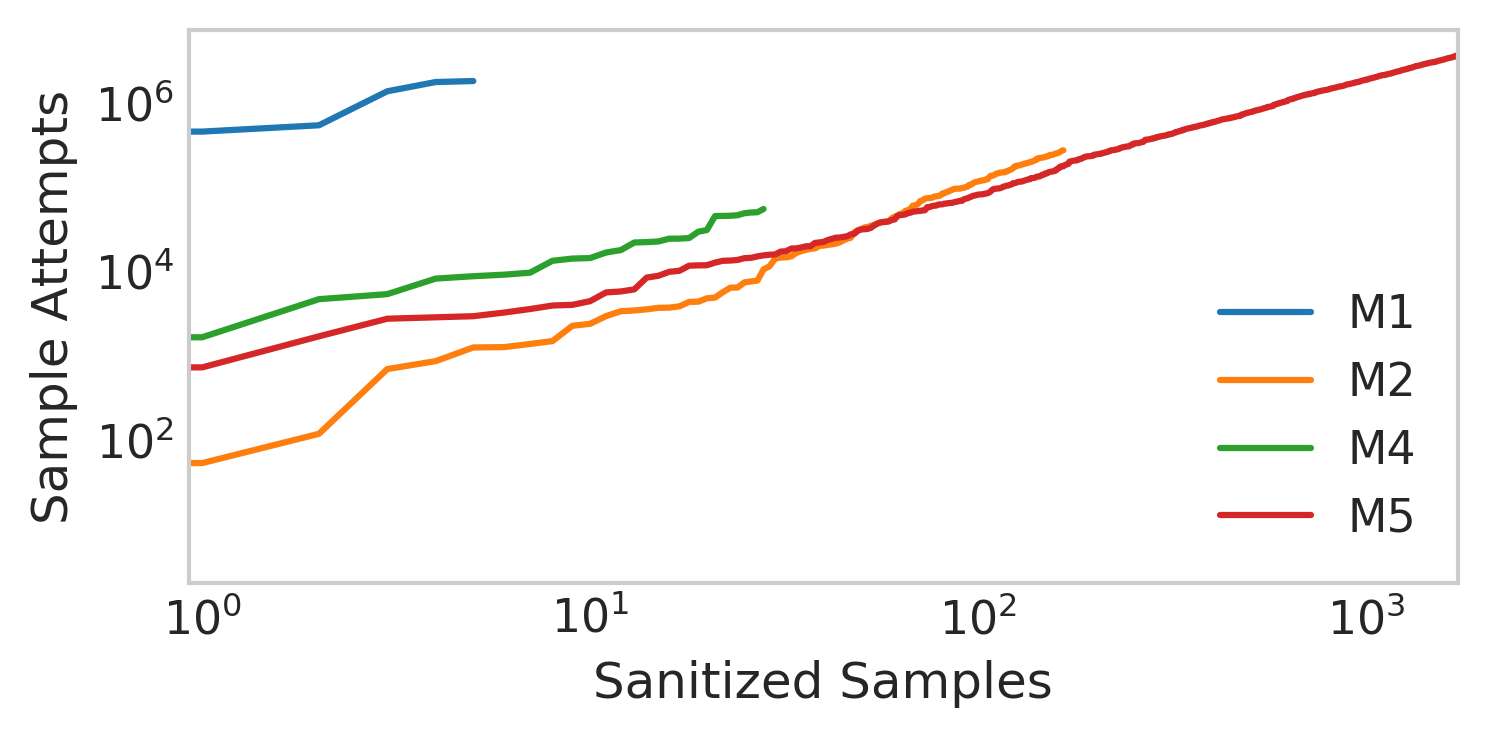

In [8]:
ms = [cations[0], 'CCCC[C+]1C=CC(C)=C1C', 'CCCC[C+]1C=CC(CC)=C1', cations[2]]
ms = [Chem.MolFromSmiles(smi) for smi in ms]
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(5,2.5), dpi=300)
    ax = fig.add_subplot(111)
    tab = my_colors()
#     for i, df in enumerate(dfs): #for all returns in dfs
    ###start positive version
    for i, df in enumerate(dfs): #only for (+) mols w/o C+ in dataset
        df = df[df['smiles'].str.contains("\+")] 
        df.reset_index(inplace=True)
        print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),i+1))
        if df.shape[0] == 0:
            continue
        #end positive version
        df['iteration'].plot(label='M{}'.format(i+1), ax=ax, loglog=True, color=next(tab))
    ax.set_ylabel('Sample Attempts')
    ax.set_xlabel('Sanitized Samples')
    plt.legend()
    plt.grid()
    plt.tight_layout()

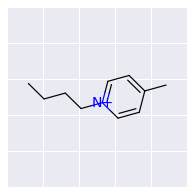

In [9]:
seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
fig = Draw.MolToMPL(seed,size=(100,100))

In [10]:
# seed_img.savefig('assets/cation_seed.png', dpi=300)

In [11]:
seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
for df in dfs:
    daylight = []
    maccs = []
    for mol in df['smiles']:
        ms = [seed, Chem.MolFromSmiles(mol)]
        fps_maccs = [MACCSkeys.GenMACCSKeys(x) for x in ms]
        fps_daylight = [FingerprintMols.FingerprintMol(x) for x in ms]
#         fps = [Chem.rdmolops.RDKFingerprint(x, useHs=False, maxPath=7) for x in ms]
        daylight.append(DataStructs.FingerprintSimilarity(fps_daylight[0],fps_daylight[1]))
        maccs.append(DataStructs.FingerprintSimilarity(fps_maccs[0],fps_maccs[1]))
    df['maccs'] = maccs
    df['daylight'] = daylight

2	 positively charged molecules in M1 w/o C+
2	 positively charged molecules in M2 w/o C+
2	 positively charged molecules in M3 w/o C+
2	 positively charged molecules in M4 w/o C+
2	 positively charged molecules in M5 w/o C+


/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


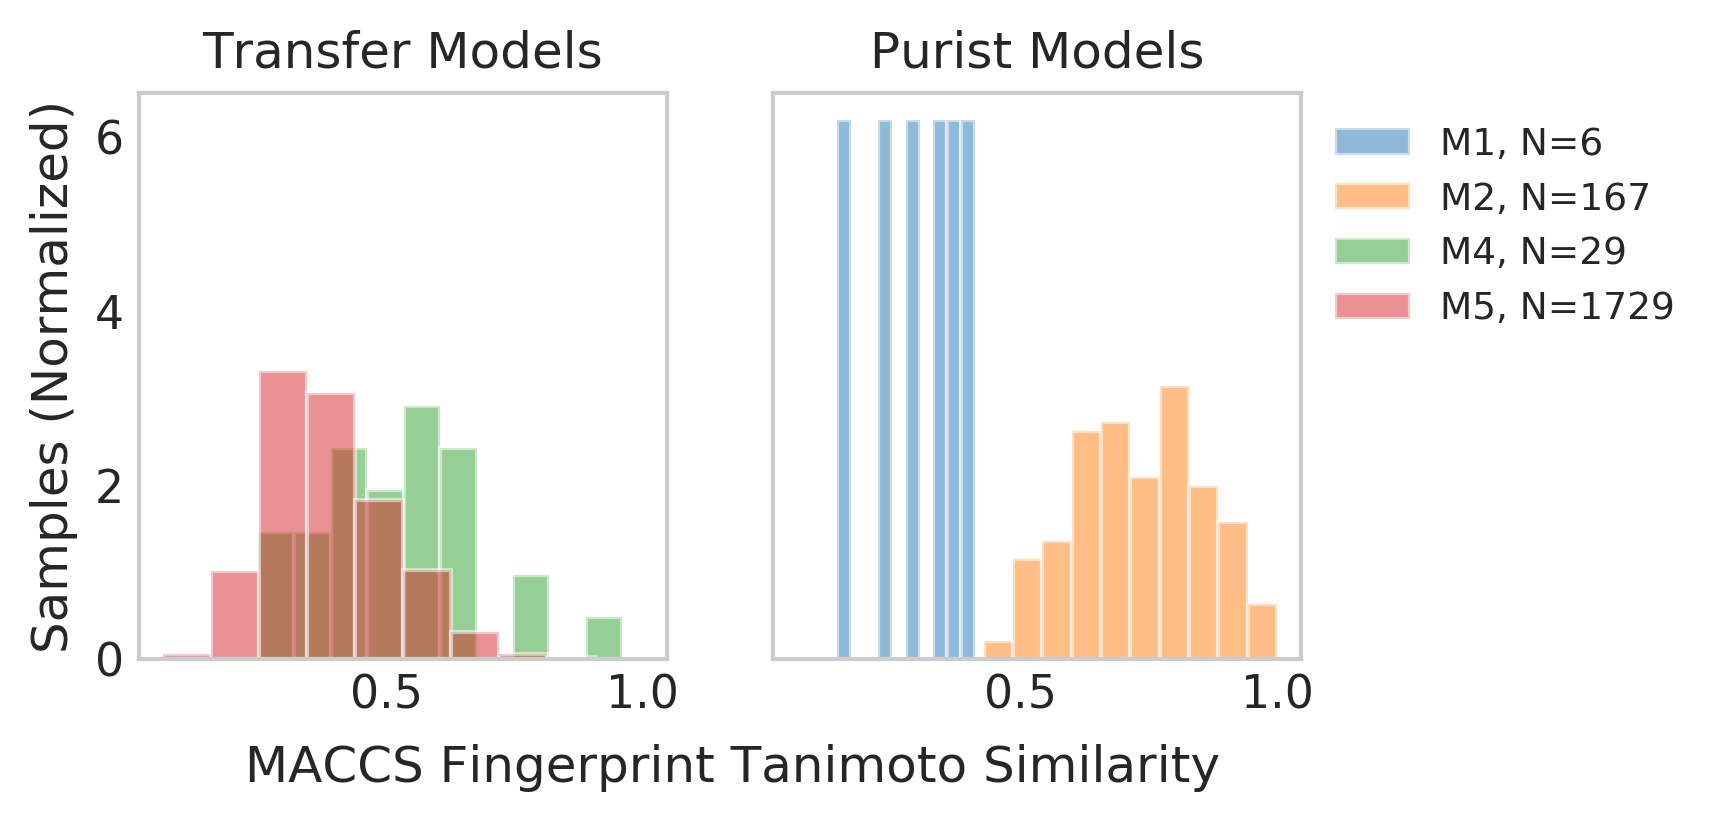

In [12]:
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.5), sharey=True, sharex=True, dpi=300)
    tab = my_colors()
        
    for index, df in enumerate(dfs):
        df = df[df['smiles'].str.contains("\+")] 
        df.reset_index(inplace=True)
        print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),index+1))
        if df.shape[0] == 0:
            continue
        if index < 3:
            df['maccs'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
        else:
            df['maccs'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
    h1, l1 = ax2.get_legend_handles_labels()
    h2, l2 = ax1.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=9, bbox_to_anchor=(1,1))
    ax1.set_ylabel('Samples (Normalized)')
    ax1.set_title('Transfer Models')
    ax2.set_title('Purist Models')
    label = ax1.set_xlabel('MACCS Fingerprint Tanimoto Similarity', fontsize = 12)
    ax1.xaxis.set_label_coords(1.125, -0.15)
#     plt.text(-1,-4,'MACCS Fingerprint Tanimoto Similarity',size=12)
    ax1.grid()
    ax2.grid()
#     plt.tight_layout()

In [13]:
# fig.savefig('assets/maccs_cation_samples_distributions_positive.svg', bbox_inches='tight', dpi=300)

**But how many of these structures are relevant?**

In [14]:
# Data For Table 1
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in df['smiles']]    
    print('{}\t total molecules in M{}'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in df['smiles'] if '+' in smi]    
    print('{}\t positively charged molecules in M{}'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [smi for smi in df['smiles'] if '+' in smi]    
    ms = [smi for smi in ms if 'C+' not in smi]
    ms = [smi for smi in ms if 'c+' not in smi]
    print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df5, df, how='inner', on='smiles')['smiles']]
    print('{}\t structures shared by M5 and M{}'.format(len(ms),i+1))

7122	 total molecules in M1
170	 total molecules in M2
6	 total molecules in M3
43	 total molecules in M4
3700	 total molecules in M5

6	 positively charged molecules in M1
167	 positively charged molecules in M2
0	 positively charged molecules in M3
29	 positively charged molecules in M4
1729	 positively charged molecules in M5

0	 positively charged molecules in M1 w/o C+
167	 positively charged molecules in M2 w/o C+
0	 positively charged molecules in M3 w/o C+
28	 positively charged molecules in M4 w/o C+
807	 positively charged molecules in M5 w/o C+

94	 structures shared by M5 and M1
9	 structures shared by M5 and M2
4	 structures shared by M5 and M3
11	 structures shared by M5 and M4
3700	 structures shared by M5 and M5


In [15]:
names = ['heat capacity', 'density', 'viscosity', 'thermal conductivity']
epochs = ['no qspr', '10 epoch', '30 epoch', '100 epoch']
dff = pd.read_csv('../data/structure_search_results/property_search_results')
dff.head()

,prop,epochs,Unnamed: 2,ani seed,attempts,candidate,cat seed,rdkit qspr,rdkit-md qspr,salt,temperature,vae qspr
0,heat capacity,no qspr,0,C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,224,CCCCCC[P+](CCCCCC)(CCCCCC)CCCCCCCCNCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,1172.270020,1155.380005,CCCCCC[P+](CCCCCC)(CCCCCC)CCCCCCCCNCCCCC.C(F)(...,1.272694,0.947480
1,heat capacity,no qspr,1,CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-],228,CCCCCCCCCCPCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,1482.560059,1475.030029,CCCCCCCCCCPCCC[P+](CCCCCC)(CCCCCC)CCCCCC.CCCCC...,1.259403,1.039302
2,heat capacity,no qspr,2,C([C@@H](C(=O)[O-])N)S,268,CCCCCCCCCCNCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,1220.020020,1229.900024,CCCCCCCCCCNCCC[P+](CCCCCC)(CCCCCC)CCCCCC.C([C@...,1.412673,0.950409
3,heat capacity,no qspr,3,CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-],415,CCCCCCCCOCCCCCCCn1cc[n+](C)c1,CCCCCCCCCCCCCCCCn1cc[n+](c1)C,1064.920044,971.559998,CCCCCCCCOCCCCCCCn1cc[n+](C)c1.CCCCC(CC)COC(=O)...,1.805683,0.921733
4,heat capacity,no qspr,4,CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-],562,CCCC[P+](CCC)(CCCC)CCCC,CCCC[P+](CCCC)(CCCC)CCCC,1202.859985,974.409973,CCCC[P+](CCC)(CCCC)CCCC.CCCCC(CC)COC(=O)CC(C(=...,1.719265,0.913552


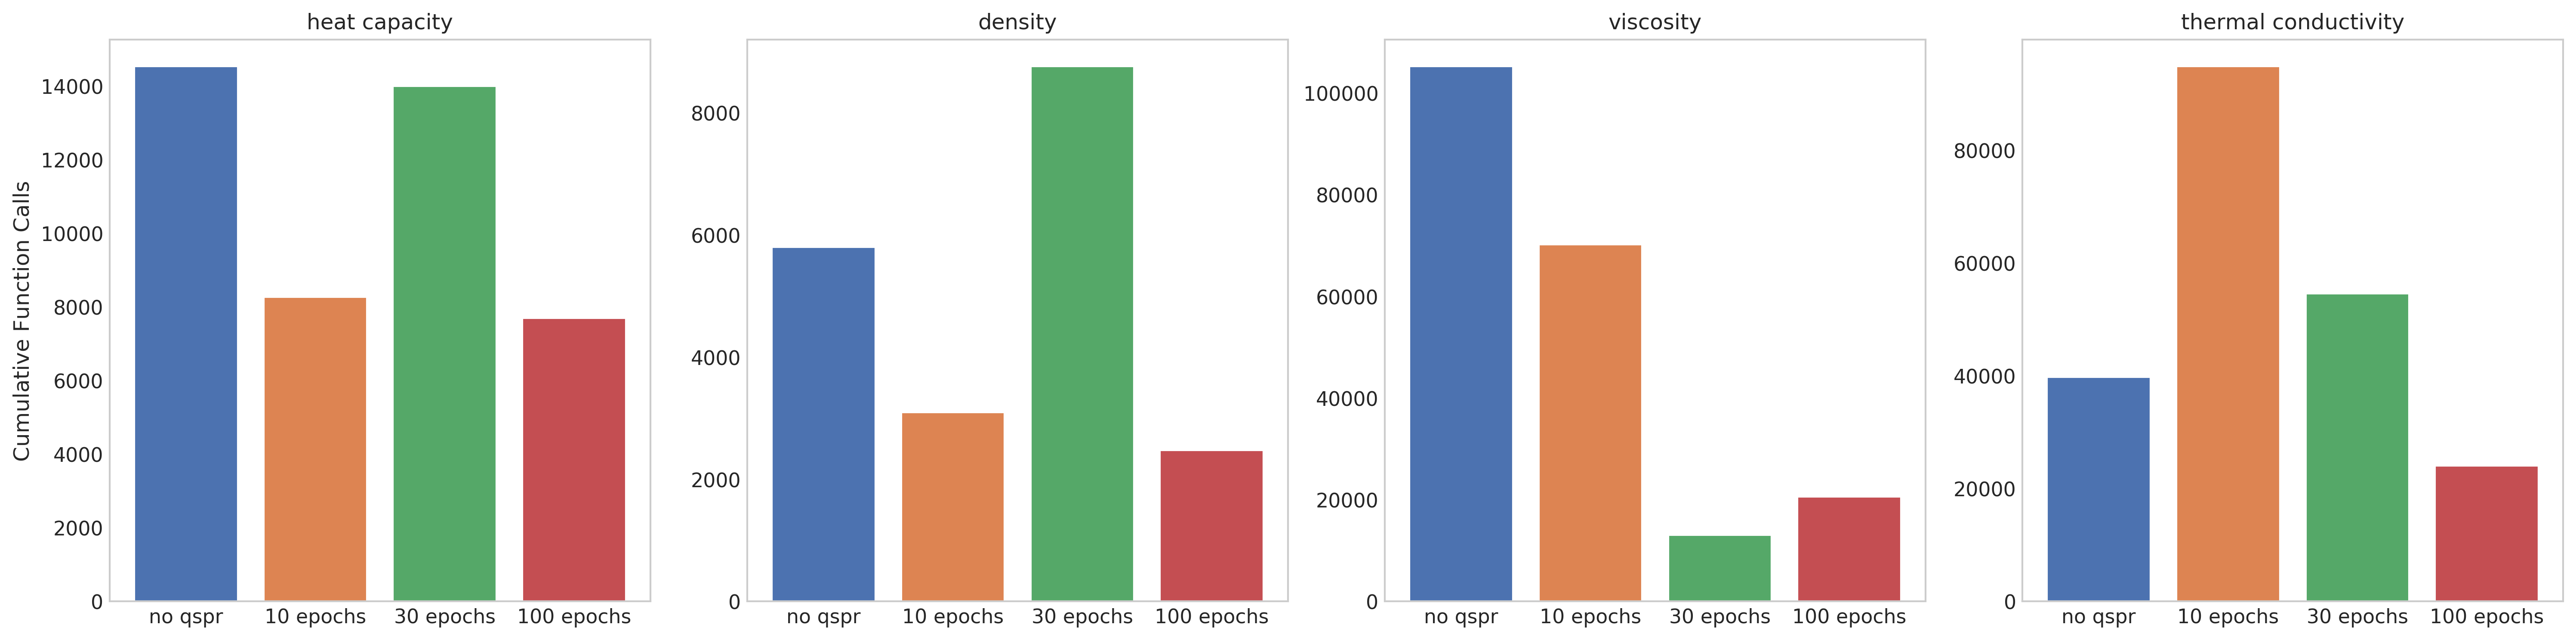

In [16]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1,4, figsize=(20,5), dpi=300, sharey=False)
    for index, dfl in enumerate(dff['prop'].unique()):
        df = dff[dff['prop'] == dfl]
        ax[index].bar(['no qspr'], df[df['epochs'] == 'no qspr']['attempts'], label='no qspr')
        ax[index].bar(['10 epochs'], df[df['epochs'] == '10 epoch']['attempts'], label='10 epochs')
        ax[index].bar(['30 epochs'], df[df['epochs'] == '30 epoch']['attempts'], label='30 epochs')
        ax[index].bar(['100 epochs'], df[df['epochs'] == '100 epoch']['attempts'], label='100 epochs')
        ax[index].set_title('{}'.format(names[index]))
        ax[index].grid()
        if index == 0:
            ax[index].set_ylabel('Cumulative Function Calls')
        
    plt.tight_layout()
#     plt.xticks(rotation=90)

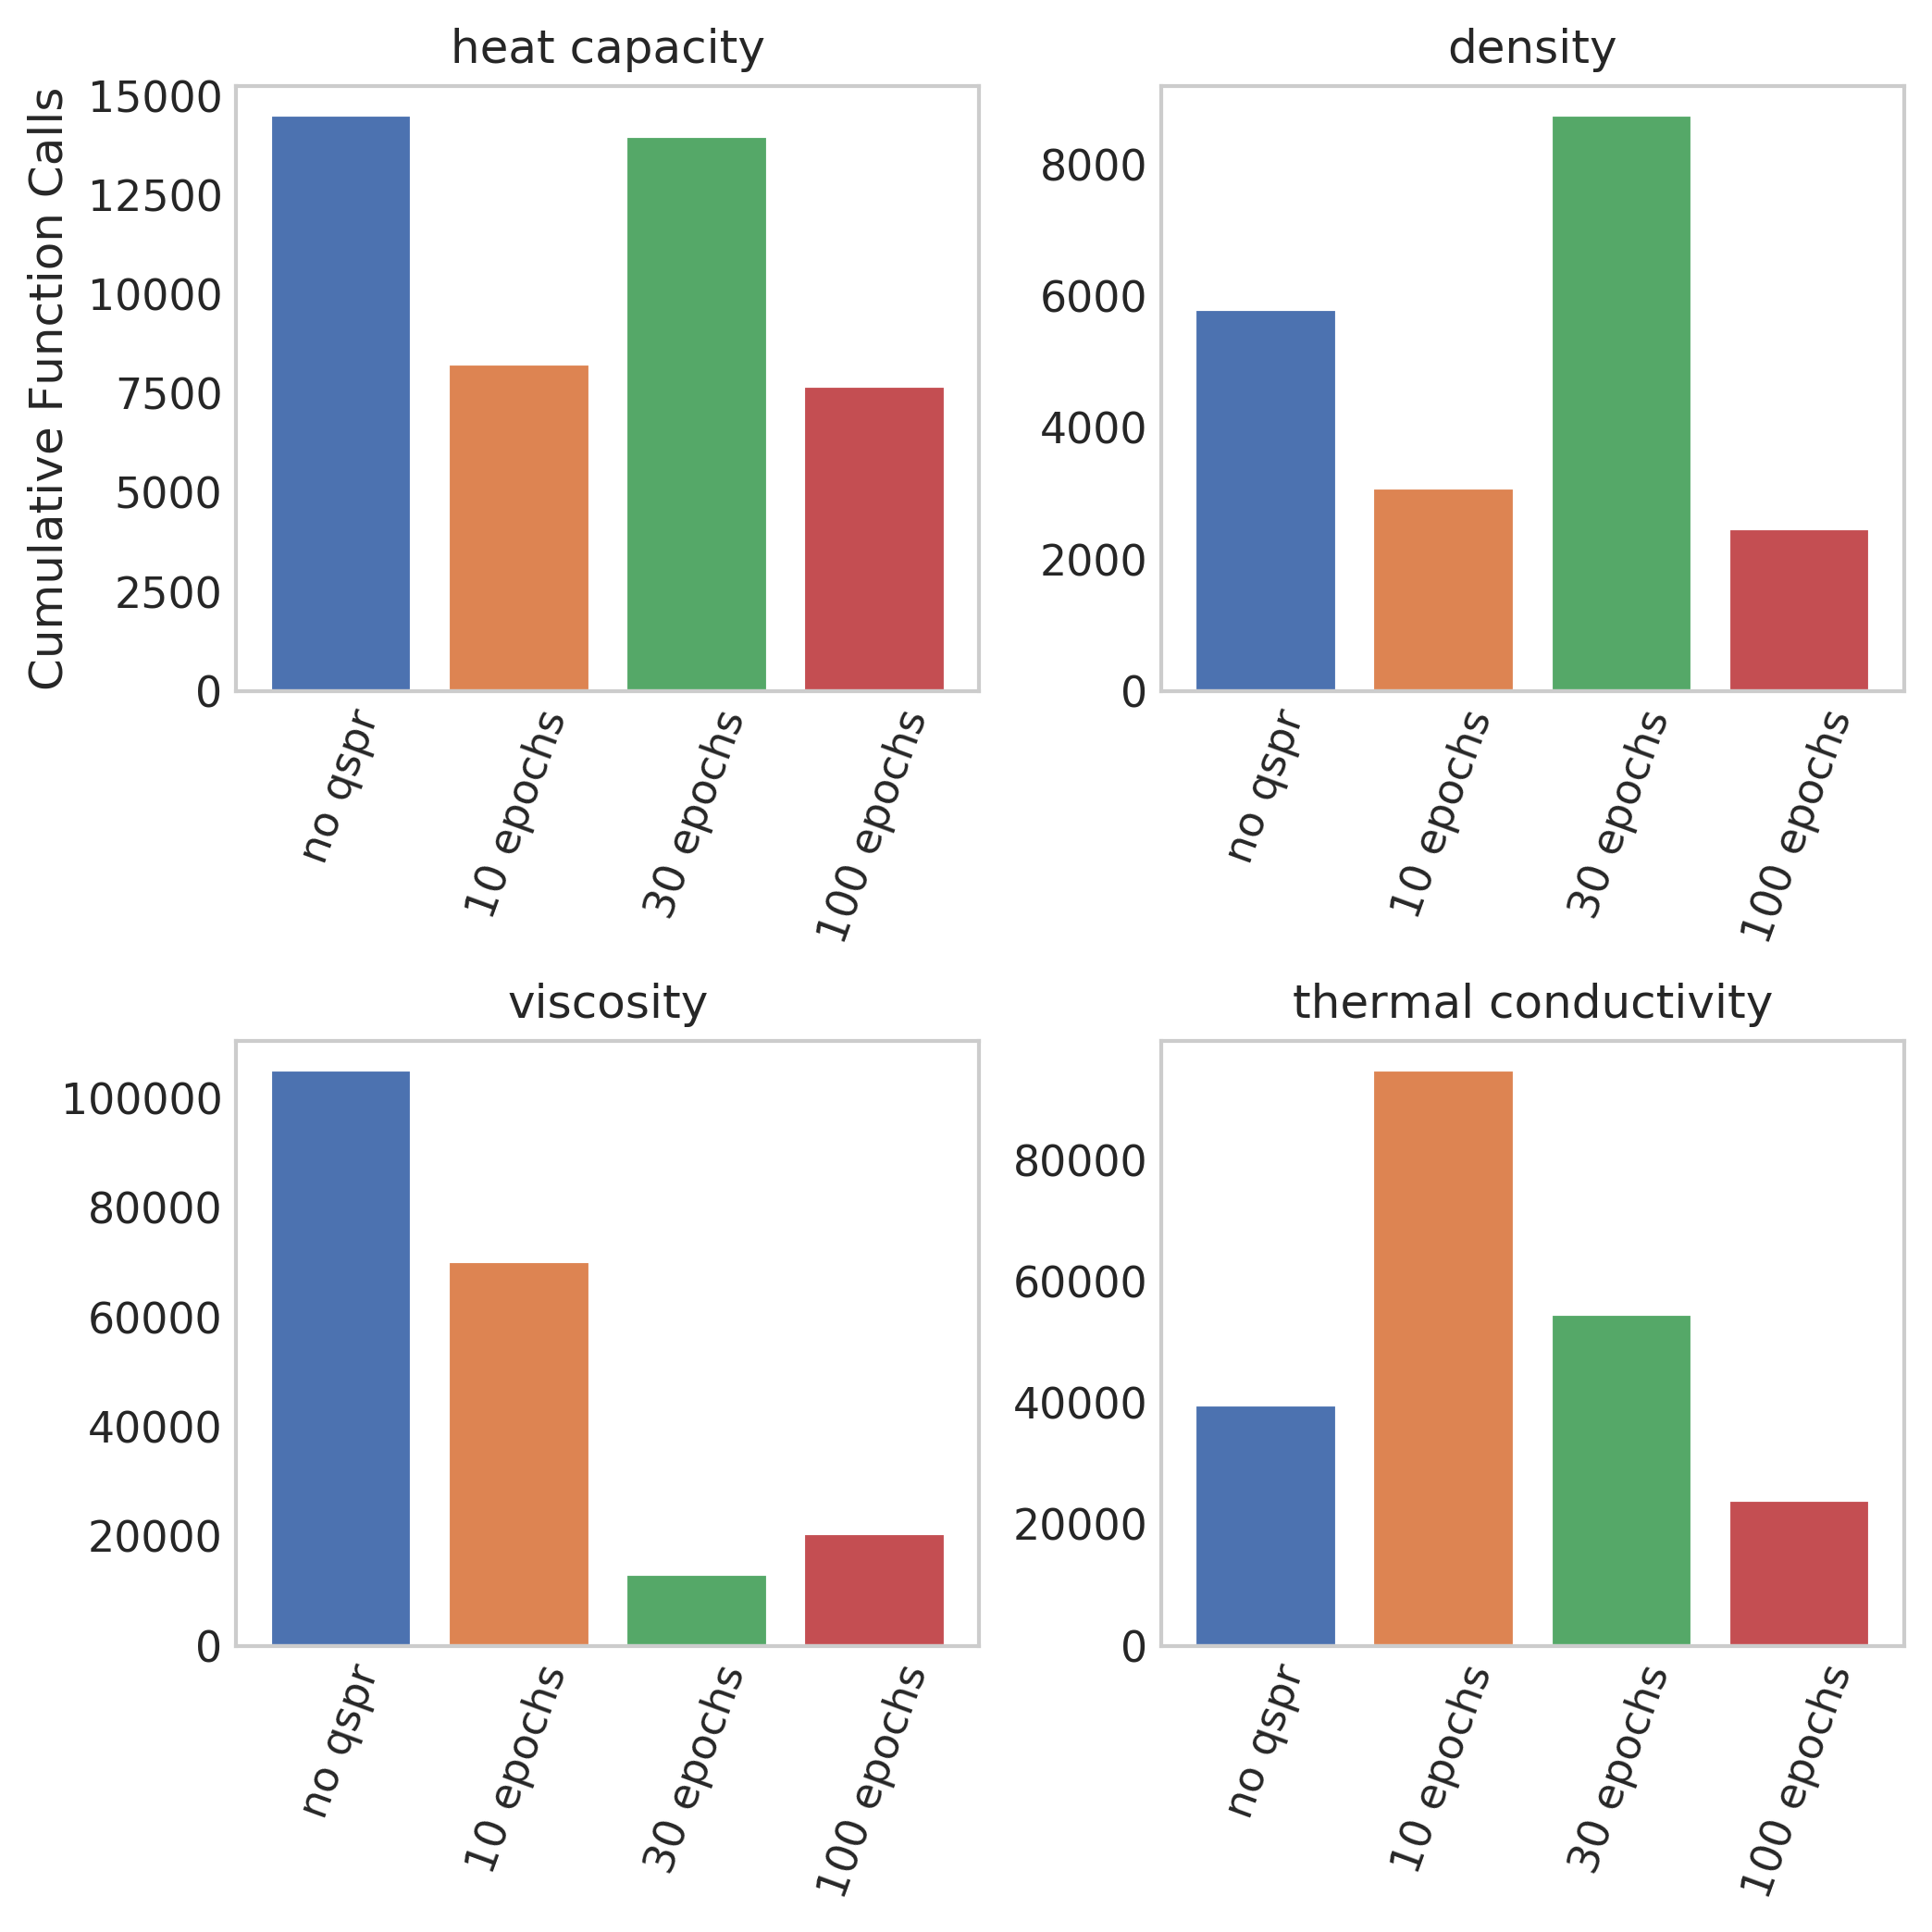

In [17]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(2,2, figsize=(7,7), dpi=300, sharey=False)
    
    index = 0
    for index1 in range(2):
        for index2 in range(2):
            
            
            df = dff[dff['prop'] == dff['prop'].unique()[index]]
            ax[index1][index2].bar(['no qspr'], df[df['epochs'] == 'no qspr']['attempts'], label='no qspr')
            ax[index1][index2].bar(['10 epochs'], df[df['epochs'] == '10 epoch']['attempts'], label='10 epochs')
            ax[index1][index2].bar(['30 epochs'], df[df['epochs'] == '30 epoch']['attempts'], label='30 epochs')
            ax[index1][index2].bar(['100 epochs'], df[df['epochs'] == '100 epoch']['attempts'], label='100 epochs')
            ax[index1][index2].set_title('{}'.format(names[index]))
            ax[index1][index2].grid()
            if index == 0:
                ax[index1][index2].set_ylabel('Cumulative Function Calls')
            plt.setp( ax[index1][index2].xaxis.get_majorticklabels(), rotation=70 )
            index += 1
    plt.tight_layout()
    #     plt.xticks(rotation=90)

In [18]:
# fig.savefig('assets/function_call_compare.svg',dpi=300)

In [32]:
import os
histories = []
for root, dirs, files in os.walk("../models/histories"):  
    for filename in files:
        if 'history' in filename:
            if 'gen' in filename:
                if 'GDB17_mix_pure' in filename:
                    histories.append(filename)
histories.sort()

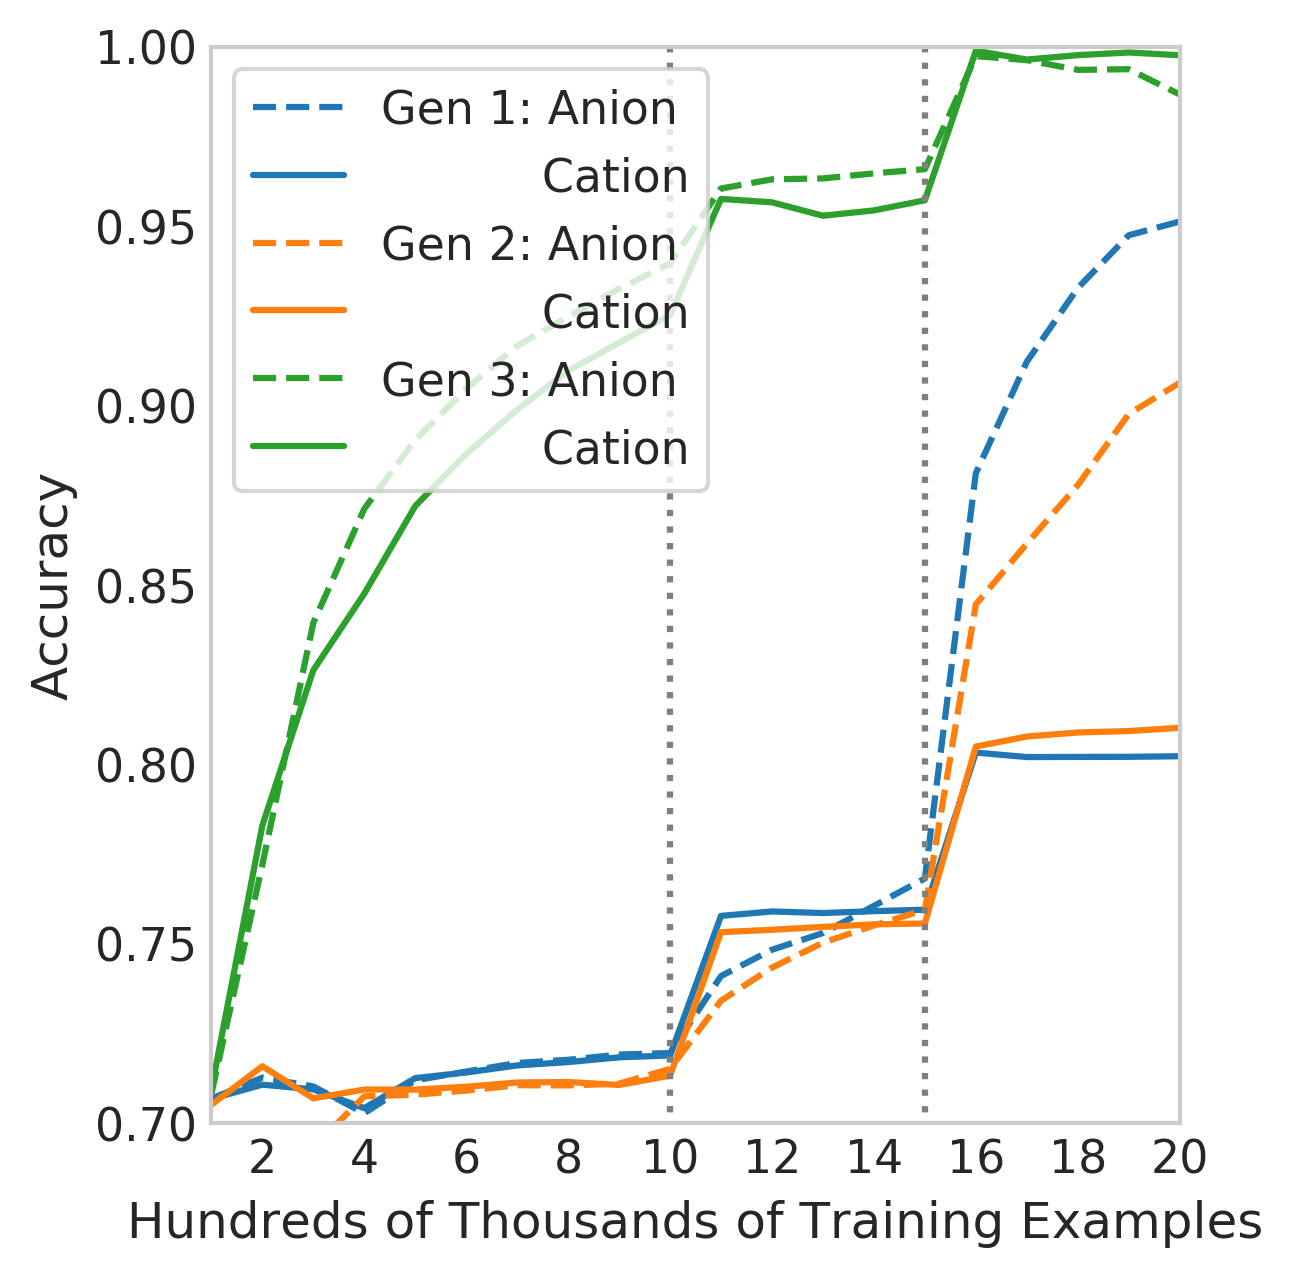

In [20]:
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(4.3,4.3), dpi=300)
    tab = my_colors()
    for i in range(3):
        col=next(tab)
        with open('../models/histories/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)
        cat = []
        ani = []
        for epoch in hist:
            if i == 0:
                ani.append(epoch['decoded_anion_mean_acc'][0])
                cat.append(epoch['decoded_cation_mean_acc'][0])
            else:
                ani.append(epoch['anion_decoded_mean_acc'][0])
                cat.append(epoch['cation_decoded_mean_acc'][0])
        ax.plot(np.arange(1,21), ani, ls='--', label="Gen {}: Anion".format(i+1), c=col)
        ax.plot(np.arange(1,21), cat, ls='-', label="           Cation".format(i+1), c=col)
        ax.set_xlim(1,20,1)
        ax.set_ylim(0.7,1)
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Hundreds of Thousands of Training Examples')
        
        ax.legend(loc=2, frameon=True)
    ax.plot([10,10],[0.6,1.1], ls=':', c='tab:grey')
    ax.plot([15,15],[0.6,1.1], ls=':', c='tab:grey')
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    fig.tight_layout()
    plt.grid()


In [21]:
import os
histories = []
for root, dirs, files in os.walk("../models/histories"):  
    for filename in files:
        if 'history' in filename:
            if 'gen3vae' in filename:
                if '100' in filename:
                    if 'melting' not in filename:
                        if (filename.split('_')[3] == '100.json') or (filename.split('_')[3] == 'conductivity'):
                            histories.append(filename)

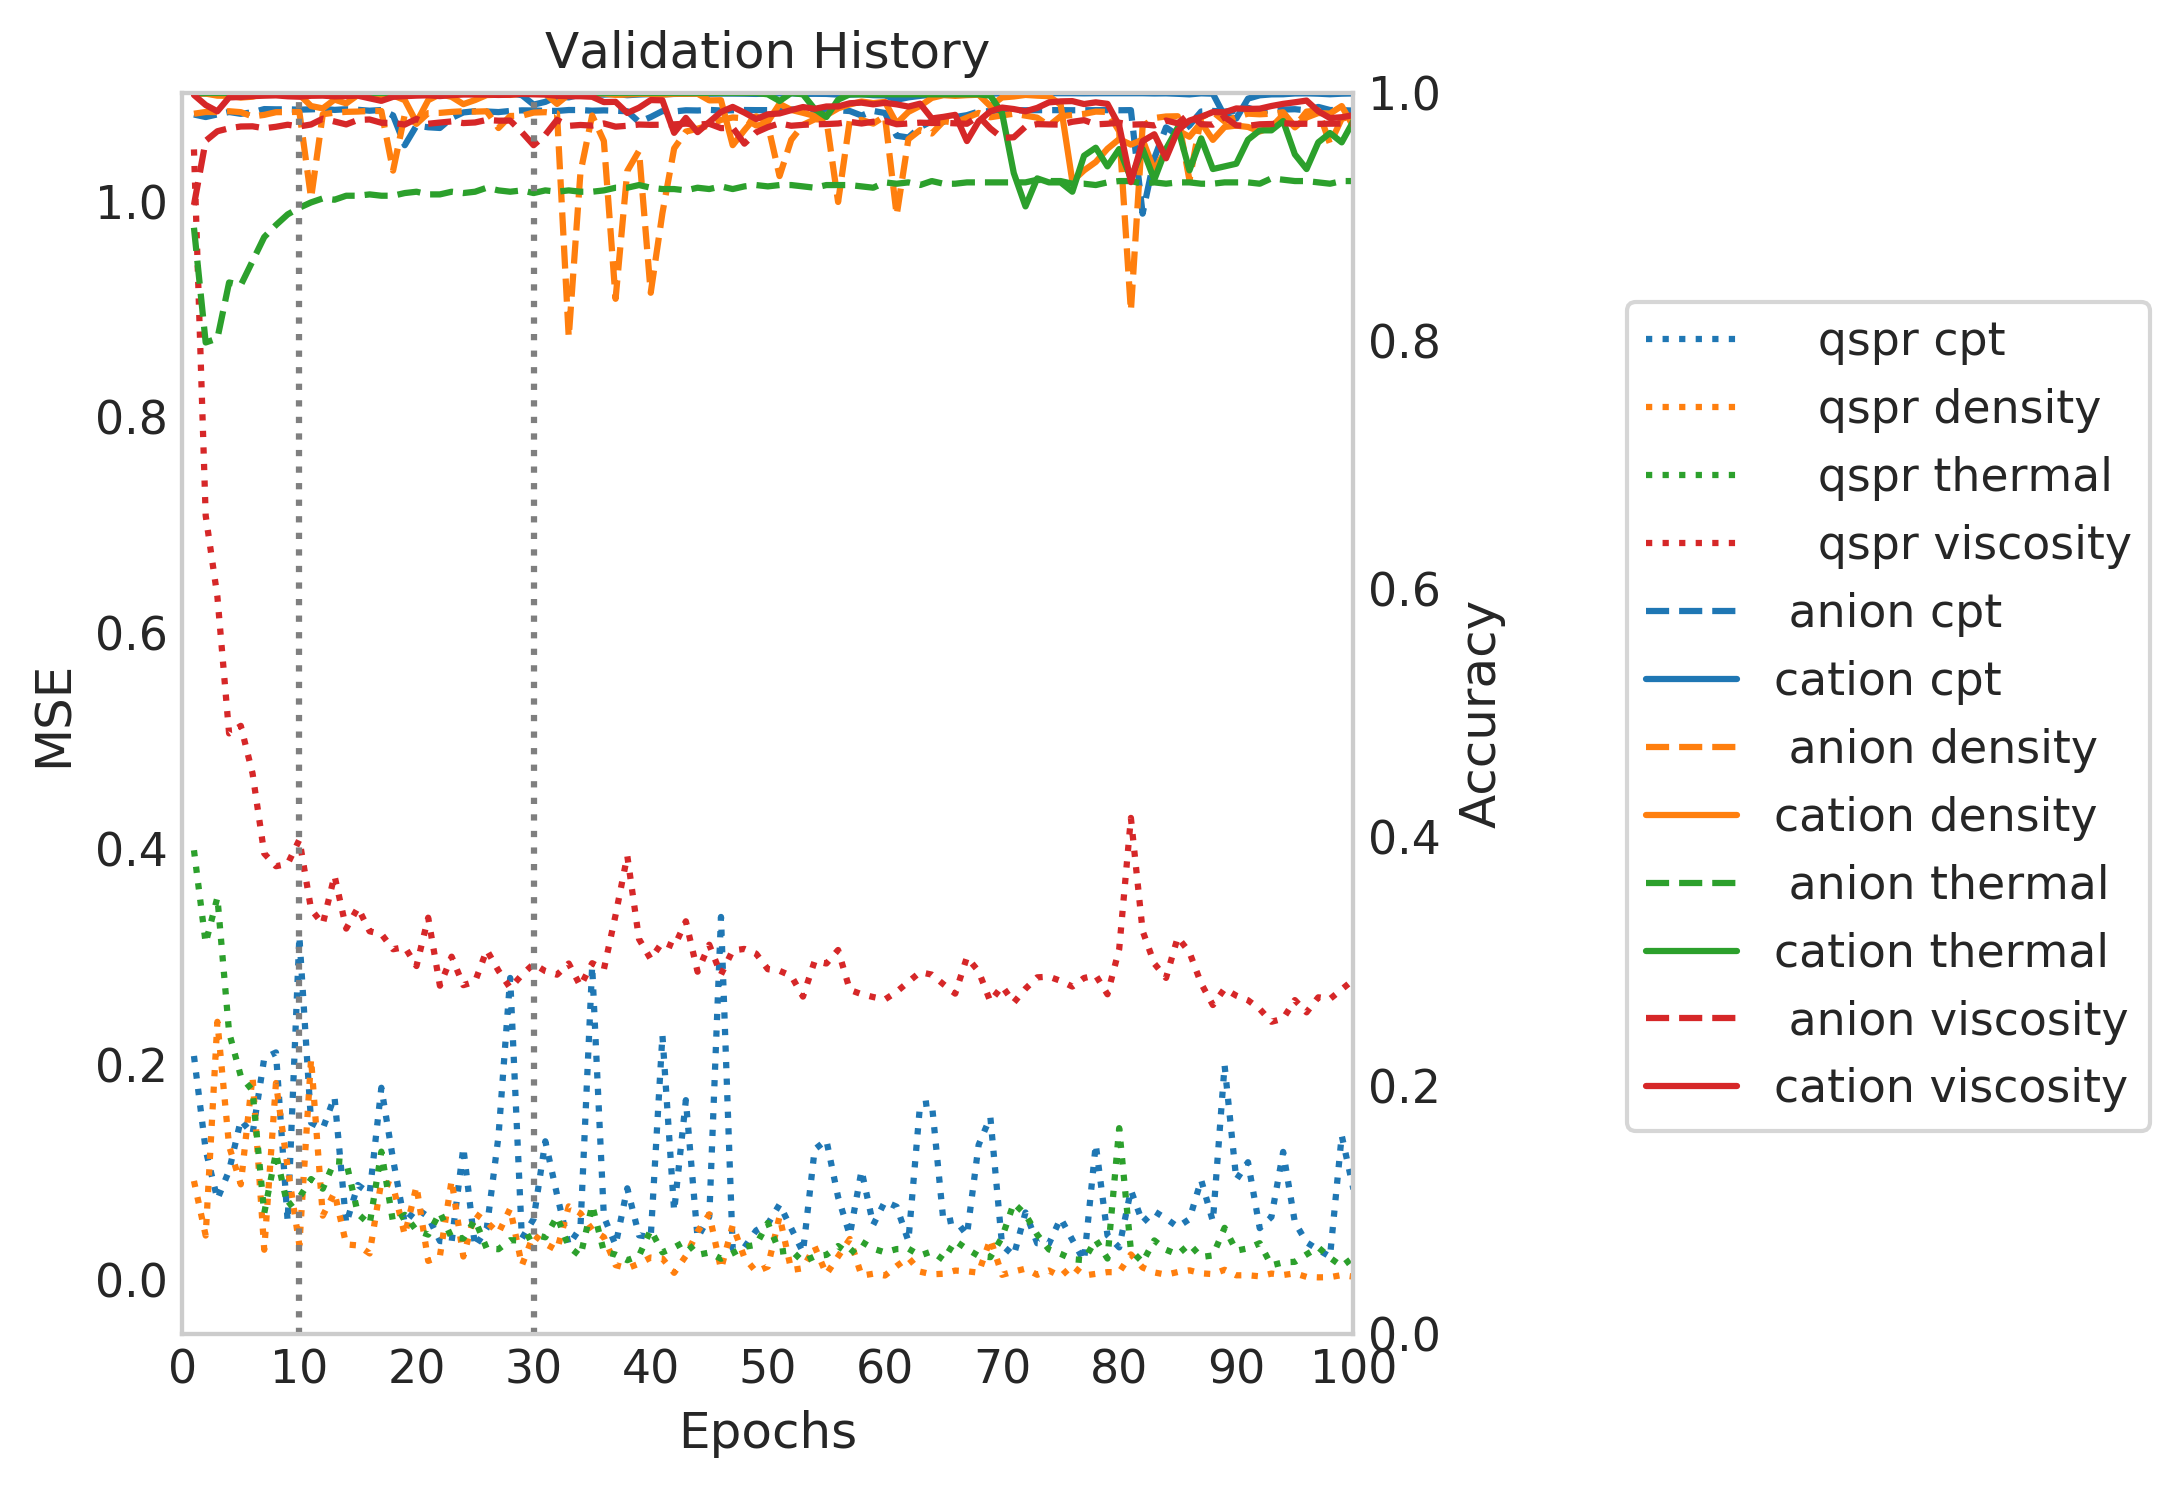

In [22]:
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(10,5), dpi=300)
    ax2 = ax.twinx()
    tab = my_colors()
    for i in range(4):
        col=next(tab)
        with open('../models/histories/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)


        ax2.plot(np.arange(1,101,1), hist['val_anion_decoded_mean_acc'], ls='--', label=" anion {}".format(histories[i].split('_')[2]), c=col)
        ax2.plot(np.arange(1,101,1), hist['val_cation_decoded_mean_acc'], ls='-', label="cation {}".format(histories[i].split('_')[2]), c=col)
        ax.plot(np.arange(1,101,1), hist['val_qspr_mean_squared_error'], ls=':', label="   qspr {}".format(histories[i].split('_')[2]), c=col)
        
        ax.set_xlim(0,100,1)
        ax2.set_ylim(0,1)
#         ax2.set_ylim(0.7,1.1)
        
        ax.set_ylabel('MSE')
        ax2.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1+h2, l1+l2, frameon=True, bbox_to_anchor=(1.7, .85))
        
    ax2.plot([10,10],[0,1], ls=':', c='tab:grey')
    ax2.plot([30,30],[0,1], ls=':', c='tab:grey')
    
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    ax.set_title('Validation History')
    ax2.grid()
    ax.grid()
    fig.tight_layout()

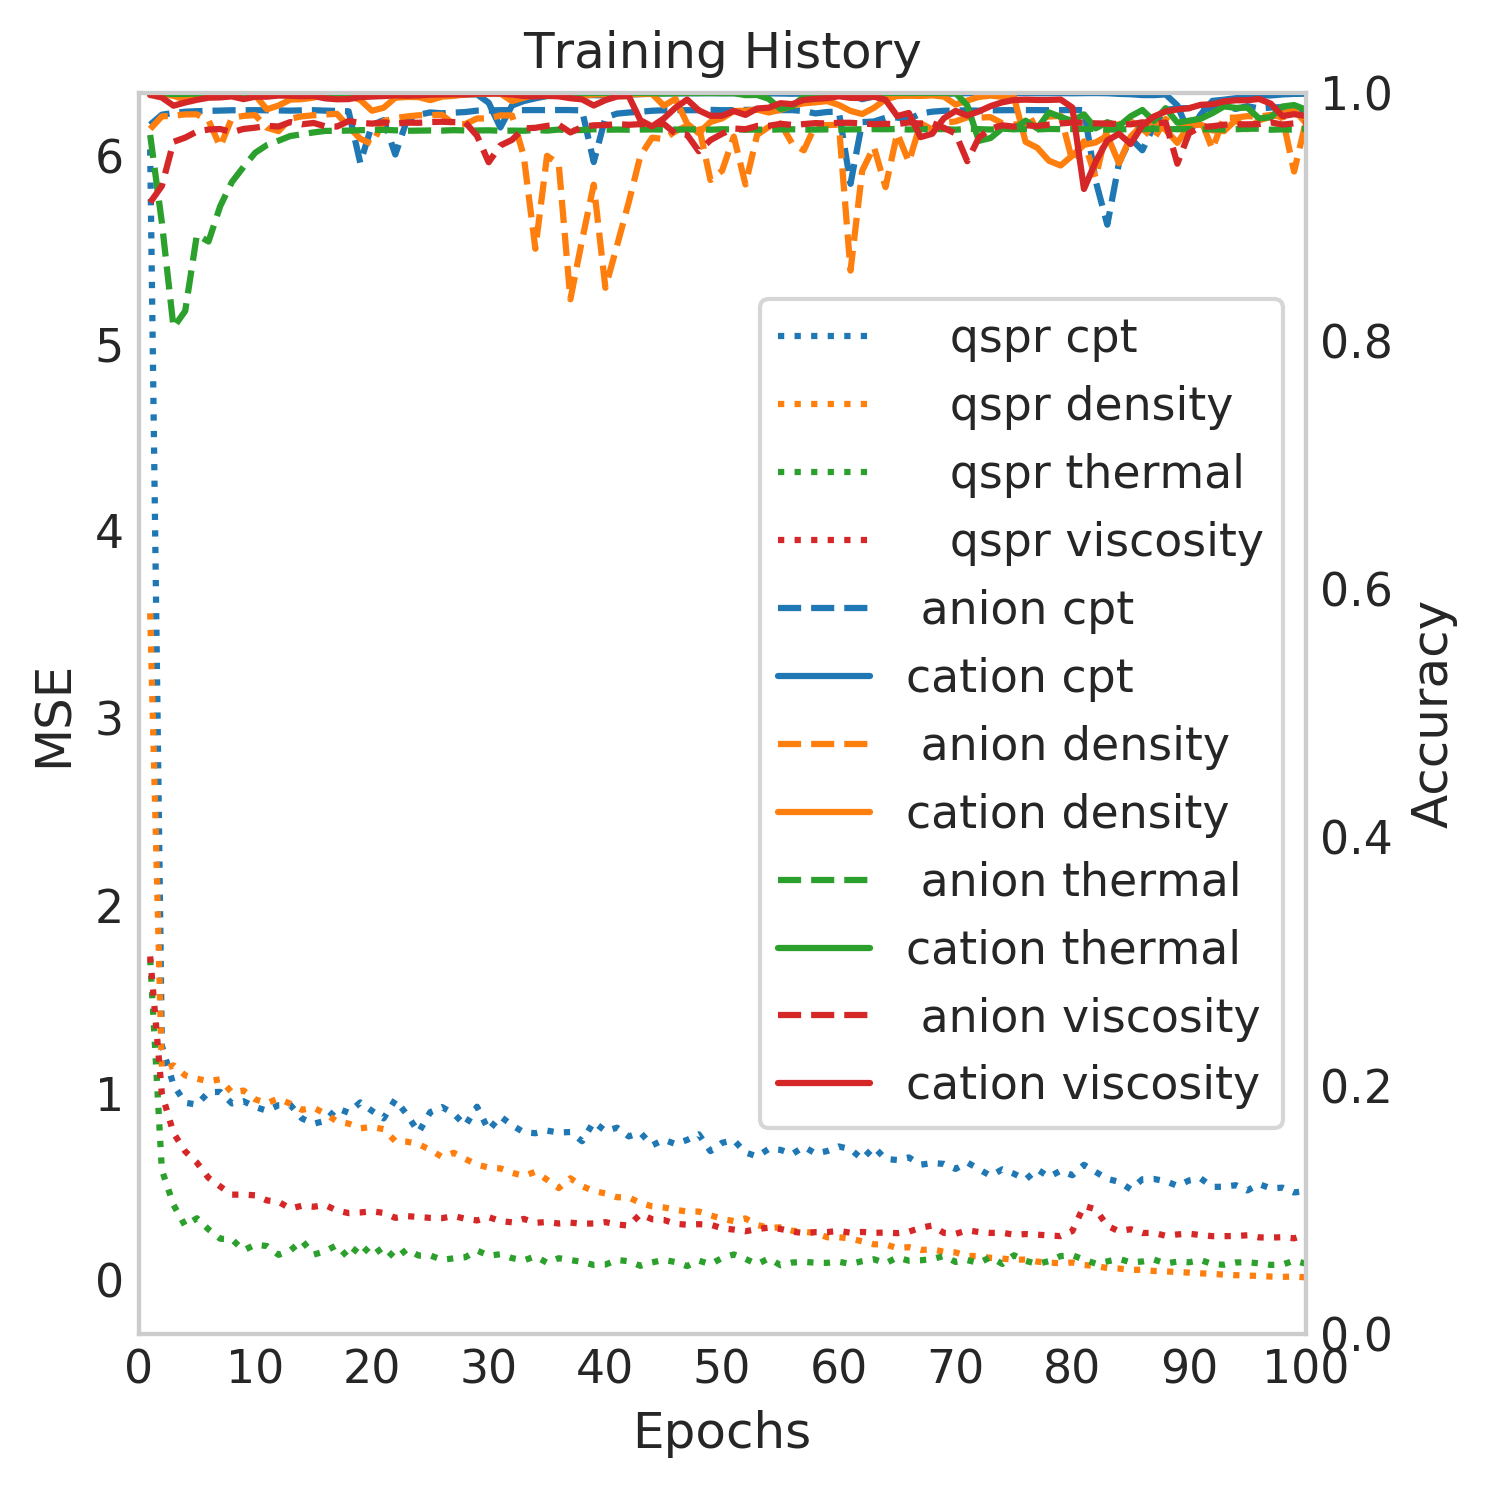

In [23]:
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
    ax2 = ax.twinx()
    tab = my_colors()
    for i in range(4):
        col=next(tab)
        with open('../models/histories/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)

        ax2.plot(np.arange(1,101,1), hist['anion_decoded_mean_acc'], ls='--', label=" anion {}".format(histories[i].split('_')[2]), c=col)
        ax2.plot(np.arange(1,101,1), hist['cation_decoded_mean_acc'], ls='-', label="cation {}".format(histories[i].split('_')[2]), c=col)
        ax.plot(np.arange(1,101,1), hist['qspr_mean_squared_error'], ls=':', label="   qspr {}".format(histories[i].split('_')[2]), c=col)
               
        ax.set_xlim(0,100,1)
        ax2.set_ylim(0,1)
        ax.set_ylabel('MSE')
        ax2.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1+h2, l1+l2, frameon=True, framealpha=0.8, loc='right')#, bbox_to_anchor=(1.7, .85))

    ax.set_title('Training History')
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    ax2.grid()
    ax.grid()
    fig.tight_layout()
#     plt.grid()


# choose two properties, number of top molecules, etc.

In [24]:
properties = ['cpt', 'thermal_conductivity'] #can change to whatever two properties
T = [297, 316] #state variables for target property values (visc, cpt, therm... etc)
P = [99, 102]

devmodel = salty.aggregate_data(properties, T=T, P=P, merge='overlap')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
cpt_thermal_salts = devmodel.Data['smiles_string']
cpt_thermal_salts = cpt_thermal_salts.reset_index(drop=True)
cpt_thermal_salts = cpt_thermal_salts.unique()

cpt_thermal_cations = [i.split('.')[0] for i in cpt_thermal_salts]
cpt_thermal_anions = [i.split('.')[1] for i in cpt_thermal_salts]

/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [25]:
print('models/gen3vae_{}_{}_100.h5'.format(properties[0], properties[1]))

models/gen3vae_cpt_thermal_conductivity_100.h5


In [26]:
#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
ani_char_to_index = json.loads(f.read())
ani_char_set = set(ani_char_to_index.keys())
ani_char_list = list(ani_char_to_index.keys())
ani_chars_in_dict = len(ani_char_list)
ani_index_to_char = dict((i, c) for i, c in enumerate(ani_char_list))

#training array info
import json
f = open("../data/gdb_char_to_index.json","r")
cat_char_to_index = json.loads(f.read())
cat_char_set = set(cat_char_to_index.keys())
cat_char_list = list(cat_char_to_index.keys())
cat_chars_in_dict = len(cat_char_list)
cat_index_to_char = dict((i, c) for i, c in enumerate(cat_char_list))

char_to_index = ani_char_to_index
char_set = ani_char_set
char_list = ani_char_list
chars_in_dict = ani_chars_in_dict
index_to_char = ani_index_to_char

In [27]:
gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, 
               weights_file='../models/gen3vae_{}_{}_100.h5'.format(properties[0], properties[1]),
              qspr_outputs = 2)

In [28]:
model_1 = [properties[0]]
salts_1, cations_1, target_1 = return_top_cations(model_1, return_min_values=True)
model_2 = [properties[1]]
salts_2, cations_2, target_2 = return_top_cations(model_2, return_min_values=False)

/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739
unique salts:	15
unique cations:	10
min/max values:	918.0000, 9000.0000

salts sorted in descending order and the minimum value of the top 10 unique cations was returned
Thermal conductivity, W/m/K
total salts in training data:	148
unique salts:	11
unique cations:	10
min/max values:	0.1060, 0.1300

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


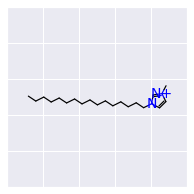

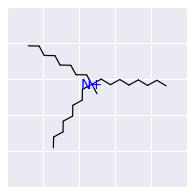

In [29]:
cat1 = cations_1[random.randint(0,len(cations_1)-1)]
im1 = Draw.MolToMPL(Chem.MolFromSmiles(cat1), size=(100,100))
cat2 = cations_2[random.randint(0,len(cations_1)-1)]
im2 = Draw.MolToMPL(Chem.MolFromSmiles(cat2), size=(100,100))

In [30]:
values = [cat1,cat2]

z = []
for smi in salts:
    smi = smi.split('.')[0]
    z_i = gen3vae.cation_encoder.predict(one_hot(smi, char_to_index, smile_max_length=62))
    z.append(z_i[0])
z = np.array(z)

zt = []
for smi in values:
    zti = gen3vae.cation_encoder.predict(one_hot(smi, char_to_index, smile_max_length=62))
    zt.append(zti[0])
zt = np.array(zt)
# we can interpolate between these molecules...
ps = array([slerp(zt[0], zt[1], t) for t in np.arange(0.0, 1.0, 0.1)])

zt = np.concatenate([zt, ps])
pca = PCA(n_components=50)
pcs = pca.fit_transform(z)
pcst = pca.transform(zt)

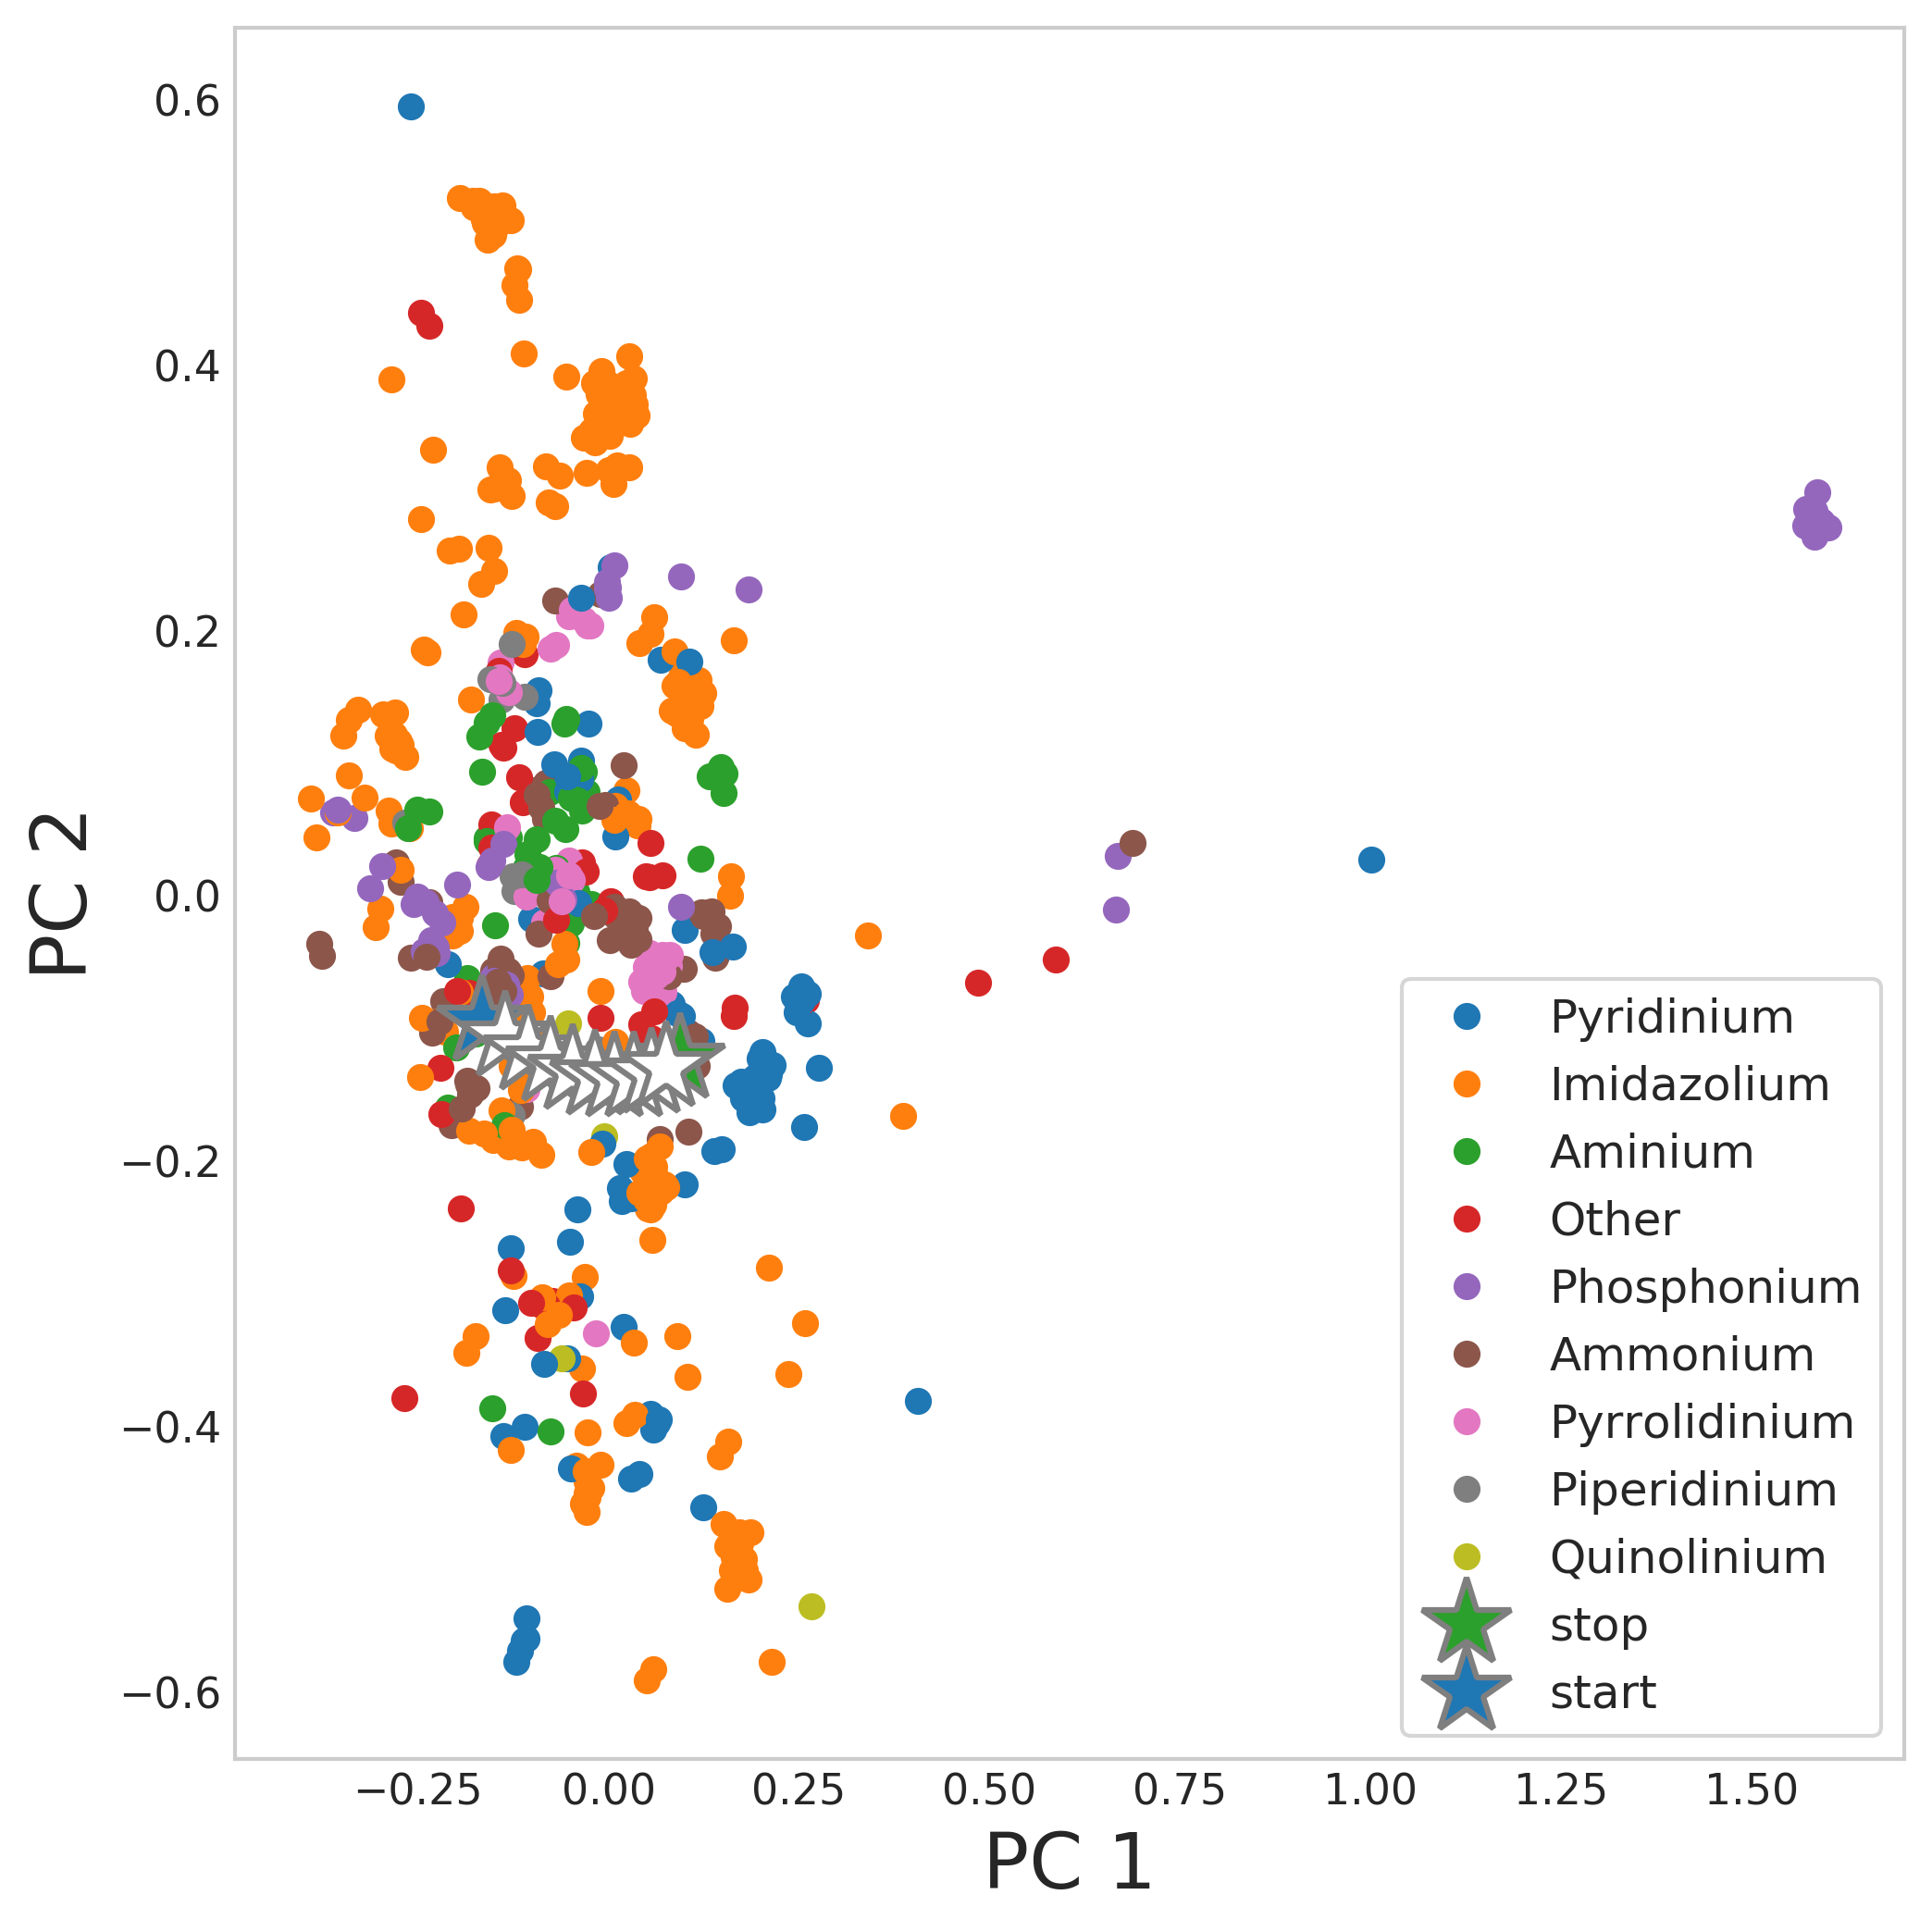

In [31]:
from collections import OrderedDict
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(7,7), dpi=300)
    ax1 = fig.add_subplot(111)
    for i in range(len(salt_categories)):
        x = pcs[i,0]
        y = pcs[i,1]
        ax1.plot(x, y, linestyle='', marker='.', 
                 color=coldic[salt_categories[i]], markersize=12, label=salt_categories[i])
    for index, targets in enumerate(pcst):
        if index == 2:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                 color='tab:blue', markersize=24, label='start', 
                     markeredgewidth=1.5, markeredgecolor='tab:grey')
        elif index == 1:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                 color='tab:green', markersize=24, label='stop',
                     markeredgewidth=1.5, markeredgecolor='tab:grey')
        else:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                     color='white', markersize=24,
                     markeredgewidth=1.5, markeredgecolor='tab:grey')
#         ax1.text(targets[0], targets[1], '{}'.format(index), fontsize=12)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax1.set_ylabel('PC 2', size=20)
    ax1.set_xlabel('PC 1', size=20)
    plt.legend(by_label.values(), by_label.keys(), frameon=True, fontsize=12)
    plt.grid()
    plt.tight_layout()